
# Projet: Facebook BaBi tasks
Notebook de la semaine du 08/03
Par Thierry Loesch et Bryce TIchit

Différents modèles sont étudiés durant cette séance:

Les résultats de précision sont pour la première tache.

- Modèle symétrique LSTM : Un embedding et un LSTM pour chaque modèle et un merge concat
    
    Précision: 36%
- Modèle LSTM sur le modèle des questions, merge concat puis LSTM sur le modèle fusionné
    
    Precision: 48%
    
- Modèle Bi-LSTM avec couche dense en sortie de chaque sous-modèle

    Précision: 35%
    
    
Nous avons par la suite modifié le code afin d'implémenter un ensemble de validation, les résultats obtenus sont les suivants,

Modèle symétrique LSTM: 36%
Modèle LSTM sur les questions: 46% 
Modèle Bi-LSTM: 36%

Par la suite nous avons augmenté la taille des ensembles, 

Training: 5500 samples , Test: 2200 samples , Validation: 2200 samples

Modèle LSTM sur les questions: 66%

Modèle symétrique LSTM: 37%

Modèle Bi-LSTM: 36%

On remarque que les modèles symétrique LSTM et Bi-LSTM n'arrivent pas à progresser malgré l'augmentation de le taille des ensembles, ils peuvent toutefois peut être être amélioré avec des couches Dropout par exemple pour améliorer la généralisation?

Le modèle LSTM sur les questions lui reste en haut du podium, avec une précision de 66% (gain de 20 points) il obtient des résultats très correct. Il est très intéressant de voir que ce modèle permet une précision bien supérieure à ses congénères, le fait d'avoir déjà un réseau LSTM sur les questions lui permet probablement de mieux raisonner par la suite sur les histoires.

Tout cela se confirme avec les courbes d'apprentissages de ces différents modèles (l'évolution des métriques [précision/perte] en fonction du nombre d'épochs), en effet le modèle symétrique LSTM et le modèle Bi-LSTM n'arrivent pas à généraliser. En effet on voit que le taux de perte diminue de plus en plus sur l'ensemble d'apprentissage alors qu'il augmente sur l'ensemble de validation (à partir de l'epoch 7 environ) ce qui est caractéristique d'un sur-apprentissage et du fait que le modèle n'arrive pas à généraliser.

En revanche le modèle LSTM sur les questions affiche des performances bien meilleures, on voit que le taux de perte sur l'ensemble d'apprentissage suit de près le taux de perte sur l'ensemble de validation ce qui est caractéristique d'un modèle qui arrive à bien généraliser. Cette courbe nous apprends également que le taux de perte converge déjà à partir de l'epoch 15, on peut donc diminuer largement le nombre d'épochs que l'on utilise et passer de 60 epochs à 20 epochs par exemple.

Les courbes d'apprentissage sont visibles à la fin de ce notebook.


# Rappel introduction dernier notebook

Sur ce notebook nous avons rajouté un parser afin de parser les données et nous avons fait la vectorisation de celles-ci. Un modèle a aussi été créé selon ce qui nous avions défini dans le notebook précédent. Nous avons ainsi pu commencer a faire des tests avec le modèle, et nous avons eu des résultats plutôt moyens sur la première task, environ 43% de précision. Il nous faut investiguer plus le problème pour améliorer nos performances, peut être en utilisant différents réseaux récurrents. Le réseau récurrent utilisé est LSTM sur ce notebook.

Reste à perfectionner le modèle et/ou les autres paramètres. Essayer les autres tasks également. Utiliser un Memory Network pour après?


In [2]:
import os
os.environ['OMP_NUM_THREADS']='8' #limit number of threads
import theano

In [3]:
import re

def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parserBabi(data):
    ret=list()
    story=list()
    
    for phrase in data:
        phrase = phrase.decode('utf-8').strip()
        id_phrase,phrase = int(phrase[0]),phrase[1:]
        
        if id_phrase == 1: #Nouvelle story
            story=list()
            
        if '\t' in phrase: #Si tabulation alors il s'agit de la question ainsi que de la réponse
            q, a, justif = phrase.split('\t')
            q = tokenize(q)
            
            data_story = [x for x in story if x] 
                                             
            ret.append((data_story,q,a)) #Nos données d'apprentissages
            story.append('')
        
        else: 
            #Alors la phrase est tout simplement un des élements de raisonnement et non une question
            story.append(tokenize(phrase))
            
    return ret

def readAndParse(f):
    data = parserBabi(f.readlines())
    return [([substory for substories in story for substory in substories], q , a) for story,q,a in data]


# Récupération des données

On récupère les fichiers sur internet directement avec la fonction get_file, cette fonction a l'avantage de ne pas tout retelecharger si les données sont déjà sur la machines (dans ~/.keras/datasets). Puis on applique les fonctions du parser afin de récupérer les données dans la structure que l'on veut.

In [4]:
from keras.utils.data_utils import get_file
import tarfile
from random import shuffle

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz')
except:
   print("erreur pendant le telechargement")

def trunc(f):
    s = '{}'.format(f)
    i, p, d = s.partition('.')
    return int('.'.join([i, d][:1]))

def splitData(data,split_take):
    
    size=len(data)
    
    train_prop,test_prop,val_prop = trunc(split_take[0] * size),trunc(split_take[1] * size), trunc(split_take[2] * size)
    
    return data[0:train_prop],data[train_prop:train_prop+test_prop],data[train_prop+test_prop:train_prop+test_prop+val_prop]
        

tar = tarfile.open(path)
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
#challenge = 'tasks_1-20_v1-2/en/qa19_path-finding_{}.txt'

train = readAndParse(tar.extractfile(challenge.format('train')))
test = readAndParse(tar.extractfile(challenge.format('test')))
data = train+test

proportions=(0.5,0.2,0.2) 
train,test,validation=splitData(data,proportions)

vocab = sorted(reduce(lambda x, y: x | y, (set(story + q + [answer]) for story, q, answer in train + test + validation)))
vocab_size = len(vocab) + 1
word_idx = dict(((w,i+1) for i,w in enumerate(vocab)))

story_max = max((len(x) for x,_,_ in train+test+validation))
question_max = max((len(x) for _,x,_ in train+test+validation))

print "Training: {} samples , Test: {} samples , Validation: {} samples".format(len(train),len(test),len(validation))


Using Theano backend.


Training: 5500 samples , Test: 2200 samples , Validation: 2200 samples


# Vectorisation

Comme vu en cours on doit vectoriser nos données (les assimiler a des nombres et les mettre dans des matrices) afin de pouvoir entrainer notre réseau neuronal.

La fonction pad_sequences plus bas permet de transformer notre liste de liste en matrice numpy en ajoutant des 0. pour complèter quand il n'y a pas de données.

In [5]:
#Mettons tout ça dans des matrices
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def vectorize(data,wordidx,storymaxlen,questionmaxlen):
    X,Xq,Y = list(),list(),list()
    
    lookup = lambda m : wordidx[m]
    
    for story, question, reponse in data:
        X.append(map(lookup,story))
        Xq.append(map(lookup,question))
        Yline = np.zeros(vocab_size)
        Yline[wordidx[reponse]] = 1
        Y.append(Yline)
        
    return pad_sequences(X, maxlen=story_max), pad_sequences(Xq, maxlen=question_max), np.array(Y)
        
    
X,Xq,Y = vectorize(train,word_idx,story_max,question_max)
X_test,Xq_test,Y_test = vectorize(test,word_idx,story_max,question_max)
X_val,Xq_val,Y_val = vectorize(validation,word_idx,story_max,question_max)

In [6]:
print X[0:10]
print Xq[0:10]
print Y[0:10]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  7 18 21 20 11  1  6 23 21 20 14  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7 18 21 20 11  1  6 23
  21 20 14  1  5 23 10 21 20 14  1  8 18 21 20 13  1]
 [ 0  0  0  0  7 18 21 20 11  1  6 23 21 20 14  1  5 23 10 21 20 14  1  8
  18 21 20 13  1  6 18 21 20 19  1  8 16 21 20 11  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  8 22 21 20 19  1  8 23 21 20 11  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8 22 21 20 19  1  8
  23 21 20 11  1  7 23 21 20 12  1  5 18 21 20 14  1]
 [ 0  0  0  0  0  8 22 21 20 19  1  8 23 21 20 11  1  7 23 21 20 12  1  5
  18 21 20 14  1  6 23 21 20 1

# Modèle

Ensuite nous crééons notre modèle keras, nous avions choisi donc de faire un modèle pour les story et pour les questions afin de pouvoir raisonner sur chacun d'eux différement puis de les combiner en un modèle, ainsi nous avons un seul modèle mais qui traite différement les story des questions. On a un LSTM dans le modèle des questions car il faut raisonner d'abord sur les questions seules puis les histoires avec les questions (raisonner sur les histoires seules ne veut pas dire grand chose du point de vue d'un raisonnement)

Schema modèle:

                    question_model                              story_model
                         |                                           |
                      Embedding                                  Embedding
                          |                                          |
                                                                    /
                        LSTM                                       /
                          |                                       /
                        RepeatVector                            /
                                    \                          /
                                      \_______________________/
                                                   |
                                                   |
                                              Merge(mode=sum)
                                                   |
                                                 LSTM
                                                   |
                                                 SoftMax



In [7]:
import matplotlib.pyplot as plt

def plotLearningCurves_acc(history_model):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('Precision du modele')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plotLearningCurves_loss(history_model):
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Perte sur le modele')
    plt.ylabel('Perte')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [8]:
#Model

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge,RepeatVector,Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam


embed_size = 50
batch_size=128
epochs=60

story_model = Sequential()
story_model.add(Embedding(vocab_size,embed_size,input_length=story_max))


question_model = Sequential()
question_model.add(Embedding(vocab_size,embed_size,input_length=question_max))
question_model.add(LSTM(embed_size))
question_model.add(RepeatVector(story_max)) #permet d'ajuster la taille du modèle afin de préparer un merge

model = Sequential()
model.add(Merge([story_model, question_model], mode='concat'))
model.add(LSTM(embed_size))
model.add(Dense(vocab_size))
model.add(Activation("softmax"))

model.compile(optimizer=RMSprop(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

history_lstm_question = model.fit([X, Xq], Y, batch_size=batch_size, nb_epoch=epochs,validation_data=([X_val,Xq_val],Y_val))


Train on 5500 samples, validate on 2200 samples
Epoch 1/60
5500/5500 [==============================] - 10s - loss: 1.8734 - acc: 0.1949 - val_loss: 1.6647 - val_acc: 0.3632

In [10]:
#Calcul de précision sur l'ensemble de test

loss,acc = model.evaluate([X_test,Xq_test],Y_test, batch_size=batch_size)
print "\nPerte = {:.3f}".format(loss)
print "Précision = {:.0f}%".format(acc*100)

    

2176/2200 [============================>.] - ETA: 0s
Perte = 0.719
Précision = 66%


In [6]:
#Model LSTM Symétrique Simple

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge,RepeatVector,Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam

embed_size = 50
batch_size=32
epochs=60

story_model = Sequential()
story_model.add(Embedding(vocab_size,embed_size,input_length=story_max))
story_model.add(LSTM(embed_size))


question_model = Sequential()
question_model.add(Embedding(vocab_size,embed_size,input_length=question_max))
question_model.add(LSTM(embed_size))
#question_model.add(RepeatVector(story_max)) #permet d'ajuster la taille du modèle afin de préparer un merge

model = Sequential()
model.add(Merge([story_model,question_model], mode='concat'))
model.add(Dense(vocab_size))
model.add(Activation("softmax"))

model.compile(optimizer=RMSprop(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

history_lstm_simple = model.fit([X, Xq], Y, batch_size=batch_size, nb_epoch=epochs,validation_data=([X_val,Xq_val],Y_val))

Train on 5500 samples, validate on 2200 samples
Epoch 1/60
5500/5500 [==============================] - 16s - loss: 1.6311 - acc: 0.3278 - val_loss: 1.3875 - val_acc: 0.4032

In [7]:
#Calcul de précision sur l'ensemble de test

loss,acc = model.evaluate([X_test,Xq_test],Y_test, batch_size=batch_size)
print "\nPerte = {:.3f}".format(loss)
print "Précision = {:.0f}%".format(acc*100)



2176/2200 [============================>.] - ETA: 0s

In [8]:
#Model Bi-LSTM

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge,RepeatVector,Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam

def makeBiLSTM(input_size,mode):
    left = Sequential()
    right = Sequential()
    
    backward=False
    
    for bimodel in [left,right]:
        bimodel.add(Embedding(vocab_size,embed_size,input_length=input_size))
        bimodel.add(LSTM(embed_size,go_backwards=backward))
        backward=True
    
    resulting_model = Sequential()
    resulting_model.add(Merge([left,right],mode=mode))
    resulting_model.add(Dense(embed_size))
    
    return resulting_model


embed_size = 50
batch_size=32
epochs=60

story_model = makeBiLSTM(story_max,'concat')

question_model = makeBiLSTM(question_max,'concat')

model = Sequential()
model.add(Merge([story_model,question_model], mode='concat'))
model.add(Dense(vocab_size))
model.add(Activation("softmax"))

model.compile(optimizer=RMSprop(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit([X,X,Xq, Xq], Y, batch_size=batch_size, nb_epoch=epochs,validation_data=([X_val,X_val,Xq_val,Xq_val],Y_val))


Train on 5500 samples, validate on 2200 samples
Epoch 1/60
5500/5500 [==============================] - 30s - loss: 1.6630 - acc: 0.3420 - val_loss: 1.6313 - val_acc: 0.3232

In [82]:
#Calcul de précision sur l'ensemble de test

loss,acc = model.evaluate([X_test,X_test,Xq_test,Xq_test],Y_test, batch_size=batch_size)
print "\nPerte = {:.3f}".format(loss)
print "Précision = {:.0f}%".format(acc*100)

plotLearningCurves_acc(history)
    

1100/1100 [==============================] - 2s     

Perte = 3.236
Précision = 36%


In [100]:
#Sauvegarde des calculs avec Pickle
import pickle
import sys

sys.setrecursionlimit(50000)

model_lstm_q_file = open('model_lstm_q.pck','wb')
pickle.dump((model,history_lstm_question),model_lstm_q_file)

Courbes modèle Bi-LSTM


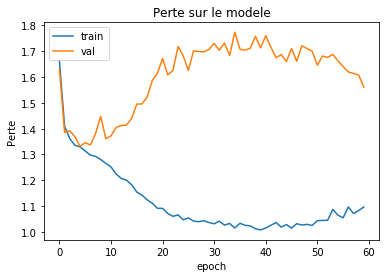

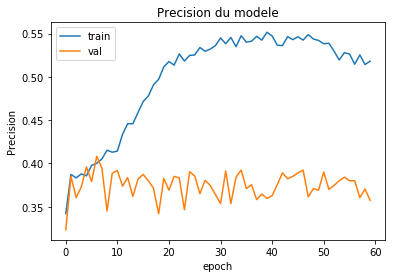

Courbes modèle LSTM symétrique


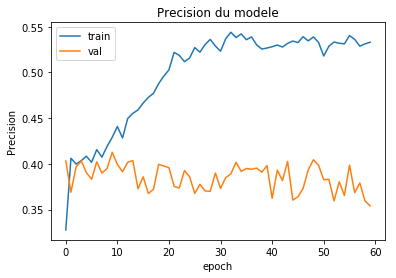

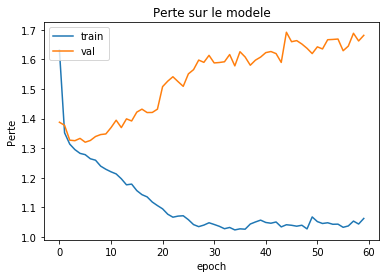

False

In [16]:
print "Courbes modèle Bi-LSTM"


plotLearningCurves_loss(history)
plotLearningCurves_acc(history)
print "Courbes modèle LSTM symétrique"

plotLearningCurves_acc(history_lstm_simple)
plotLearningCurves_loss(history_lstm_simple)

history == history_lstm_simple


Courbes modèle LSTM Questions


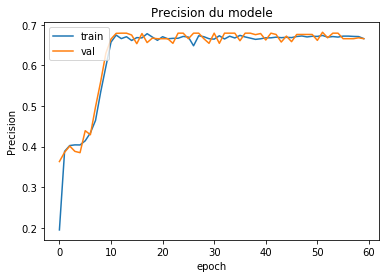

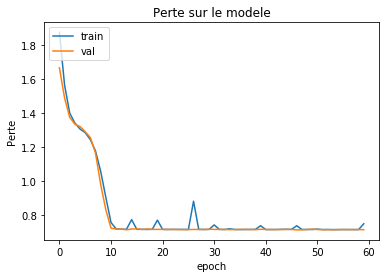

In [11]:
print "Courbes modèle LSTM Questions"

plotLearningCurves_acc(history_lstm_question)
plotLearningCurves_loss(history_lstm_question)